# Geometry Data
---
US State Boundaries as geojson polygon from https://public.opendatasoft.com/explore/dataset/us-state-boundaries/export/

In [69]:
# Dependencies
import pandas as pd
import geopandas as gpd
import requests
import shapely as shp
import fns as f
import matplotlib.pyplot as plt

## 1 Load California Geometry
---

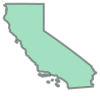

In [23]:
# Read California state boundary geojson
gdf = gpd.read_file('../data/shapes/ca_shape.geojson')
gdf.geometry[0]

In [27]:
# Import Water Plan Planning Areas
response2 = requests.get('https://gis.water.ca.gov/arcgis/rest/services/Boundaries/i03_Water_Plan_Planning_Areas/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')

In [28]:
response2

<Response [200]>

<Axes: >

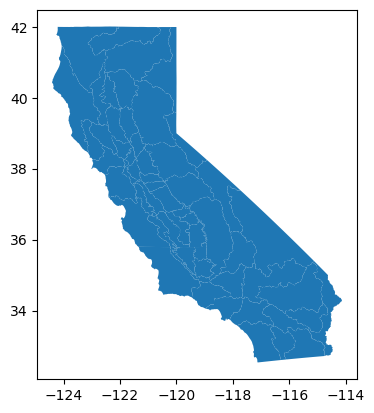

In [45]:
# Load response into geodataframe
r2gdf = gpd.GeoDataFrame.from_features(response2.json()["features"],crs=4326)
r2gdf = r2gdf.set_index('PA_NO')[['geometry','Shape__Area']]
r2gdf.plot()

In [49]:
r2gdf['region'] = ''

In [50]:
r2gdf.tail(1)

,geometry,Shape__Area,region
PA_NO,,,
905,"POLYGON ((-115.88976 35.46716, -115.89005 35.4...",2.095946e+10,


In [46]:
merge = {'Plateau':[101,501,801],
         'North Coast':[102,103],
         'North Bay':[104,201,505],
         'Central Valley':[502,503,504,506,507,509,510,511,602,603,606,607,608,609,702,703,704,705,706,708,709,710],
         'Sierras':[508,604,610,707,802], #Sierra
         'Basin Desert':[901,902,903,904,905,1001,1002,1003,1004,1005,1006],
         'Central Coast':[202,301,302,601,605,701],
         'South Coast':[401,402,403,404]}

In [51]:
for k in merge.keys():
    r2gdf.loc[[str(i) for i in merge[k]],'region'] = k

In [53]:
dissolve = r2gdf.dissolve(by='region',aggfunc='sum')
dissolve

,geometry,Shape__Area
region,,
Basin Desert,"POLYGON ((-114.74763 32.71688, -114.75080 32.7...",1.804235e+11
Central Coast,"MULTIPOLYGON (((-119.17076 34.81256, -119.1715...",6.774334e+10
Central Valley,"POLYGON ((-118.77778 35.37424, -118.77287 35.3...",1.057780e+11
North Bay,"POLYGON ((-122.12606 38.42724, -122.12590 38.4...",2.066439e+10
North Coast,"POLYGON ((-122.98954 40.14553, -122.98955 40.1...",6.330564e+10
Plateau,"POLYGON ((-120.20837 41.99400, -120.19026 41.9...",6.719967e+10
Sierras,"POLYGON ((-118.65438 37.14136, -118.65438 37.1...",1.037970e+11
South Coast,"MULTIPOLYGON (((-116.57410 33.55329, -116.5736...",4.125691e+10


<Axes: >

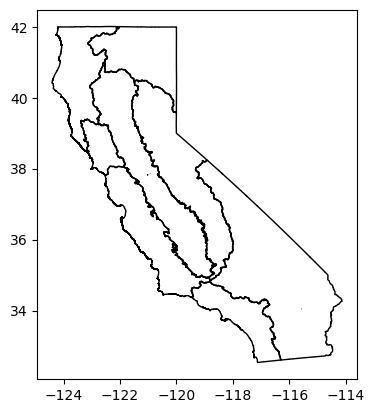

In [56]:
dissolve.plot(
    color='none',edgecolor='#000'
)

## 2 Create Grid Array
---

In [57]:
# Get California state bounds
f.CAbounds()
# Create grid size based on NASA GESDISC GPM IMERG cell size
grid_cells = []
grid_size = 0.1
for x in range(-12445,-11405+10,10):
    for y in range(3245, 4195+10,10):
        grid_cells.append(f.polysquare(x,y,5,100))
cells = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=4326)
cells.geometry[0], cells.geometry[10079]

(<POLYGON ((-124 32.4, -124 32.5, -124 32.5, -124 32.4, -124 32.4))>,
 <POLYGON ((-114 41.9, -114 42, -114 42, -114 41.9, -114 41.9))>)

## 3 Generate California Grid Array
---

In [58]:
# Creat boolean mask for grid cells based on intersect with CA boundary shape
mask = cells.intersects(gdf['geometry'][0])

In [59]:
# Create list of index for cells covering CA from mask
index = [i for (i, v) in zip(range(0,len(mask)), mask) if v]

In [60]:
# Export list of indices to csv file
pd.Series(index,name='keep').to_csv('../data/shapes/ca_grid_index_keep.csv',index=False)

In [61]:
# Create list of index for cells to be dropped from mask
drop = [i for (i, v) in zip(range(0,len(mask)), mask) if not v]

In [62]:
# Export list of indices to csv file
pd.Series(drop,name='drop').to_csv('../data/shapes/ca_grid_index_drop.csv',index=False)

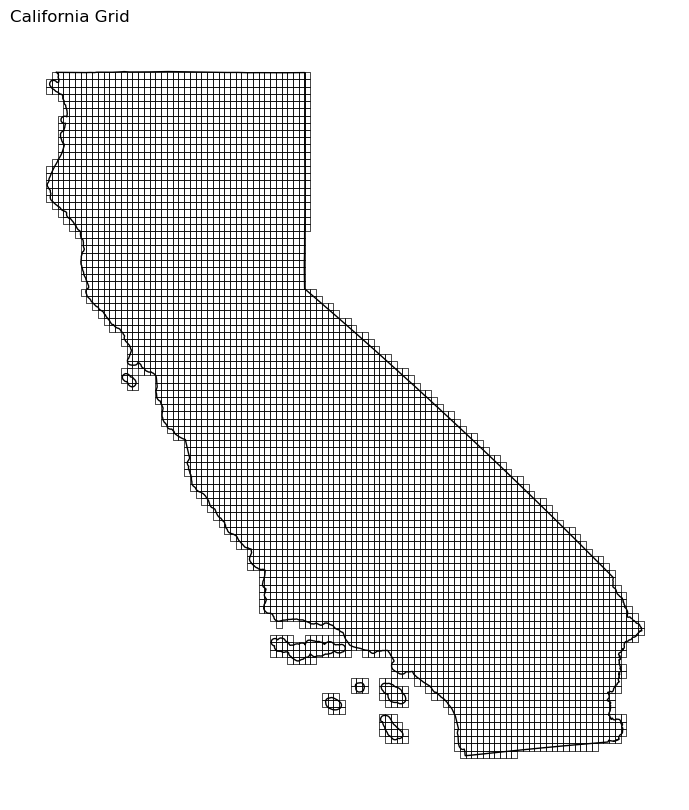

In [72]:
# Filter grid cells by index using drop list
ca_cells = cells.drop(index=drop)
ax = ca_cells.plot(
    figsize=(11,10), color='none',edgecolor='#000',zorder=3,linewidth=0.5
)
ax.axis('off')
gdf.plot(ax=ax,color='none',edgecolor='#000', zorder=2) # Plot state boundary
bbox_gdf.plot(ax=ax, color='#fff', zorder=1) # Plot state boundary
plt.title('California Grid', loc='left')
plt.savefig(f'../images/ca_grid.png')
plt.show()

## 4 Export and Validate Geometry
---

In [45]:
# Write CA cells to geojson file
ca_cells.to_file('../data/shapes/ca_grid.geojson', driver='GeoJSON')

In [46]:
# Read CA cells file to check
ca_grid = gpd.read_file('../data/shapes/ca_grid.geojson')

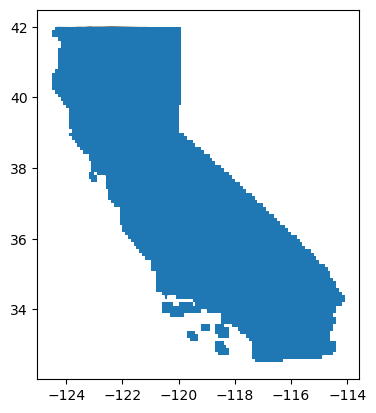

In [47]:
ax=ca_grid.plot( zorder=2)
gdf.plot(ax=ax, color='black', zorder=1)
plt.show()

## 5 Create and Export California Bounding Box
---

In [64]:
bbox = [ca_cells['geometry'].bounds['minx'].min()-0.1,
      ca_cells['geometry'].bounds['miny'].min()-0.1,
      ca_cells['geometry'].bounds['maxx'].max()+0.1,
      ca_cells['geometry'].bounds['maxy'].max()+0.1]
bbox

[-124.6, 32.4, -114.0, 42.1]

In [66]:
bbox_shp = shp.geometry.box(bbox[0],bbox[1],bbox[2],bbox[3])

In [67]:
bbox_gdf = gpd.GeoDataFrame([bbox_shp], columns=['geometry'], crs=4326)

In [75]:
bbox_gdf.to_file('../data/shapes/ca_bbox.geojson', driver='GeoJSON')